In [1]:
import matplotlib.pyplot as plt, numpy as np
from nuscenes.nuscenes import NuScenes, NuScenesExplorer
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion
# NuScenes path
nusc = NuScenes(version='v1.0-trainval', dataroot='/mnt/share/sda-8T/rj/Dateset/Nuscenes/data/nuscenes', verbose=True)
nuscExp = NuScenesExplorer(nusc)

Loading NuScenes tables for version v1.0-trainval...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
34149 lidarseg,
Done loading in 33.702 seconds.
Reverse indexing ...
Done reverse indexing in 10.4 seconds.


In [2]:
# Define class Box_with_color based on class Box
class Box_with_color(Box):
    def __init__(self, center, size, orientation: Quaternion, color = 0):
        super().__init__(center, size, orientation)
        self.color = color
def coordinate_conversion(box_list, sample_token):
    """
    Convert the global coordinate system to the background coordinate system
    Param:
        box_list: list of box.
        sample_token: sample_token of background.
    """
    new_box_list = []
    for box in box_list:
        box = Box_with_color(center=box['translation'],
                size=box['size'],
                orientation=Quaternion(box['rotation']),
                color=box['color'])
        sample_data_token = nusc.get('sample',sample_token)['data']['RADAR_FRONT']
        sd_record = nusc.get('sample_data', sample_data_token)
        pose_record = nusc.get('ego_pose', sd_record['ego_pose_token'])
        yaw = Quaternion(pose_record['rotation']).yaw_pitch_roll[0]
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse)
        new_box_list.append(box)
    return new_box_list
# Give sample_token of frame to render as background
sample_token = '98c0d0cc9433448188e863580619445d'
# Boxes from the result file
box_list = [{'translation': [2021.1061218457126, 2338.378097645742, 1.0813693483270628], 
             'size': [1.9181417226791382, 4.633460998535156, 1.6746224164962769], 
             'rotation': [0.2839252749183466, -0.002326623526533283, 0.01552589453234281, 0.9587178790887739], 
             'color': 'red'},
            {'translation': [2014.7999540195915, 2342.3674033016014, 1.1028629004764436], 
             'size': [1.9022479057312012, 4.5171895027160645, 1.6788620948791504], 
             'rotation': [0.2877885120352462, -0.00022193294043439072, 0.016492640131474414, 0.957551939013129], 
             'color': 'blue'}
            ]
box_list = coordinate_conversion(box_list, sample_token)

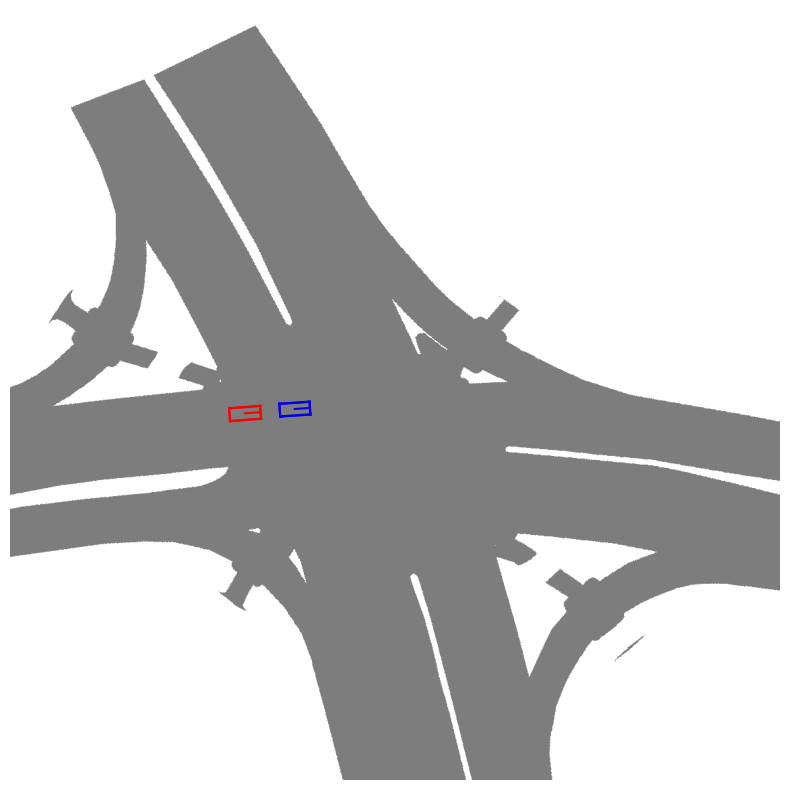

In [3]:
def render_sample(out_path: str = None,
                  axes_limit = None,
                  box_list = None,
                  sample_token = None) -> None:
    """
    Param:
        out_path: Optional path to save the rendered figure to disk.
        axes_limit: range to render.
        box_list: boxes to render.
        sample_token: sample token.
    """
    fig, ax = plt.subplots(figsize = (10,10))
    sample_data_token = nusc.get('sample', sample_token)['data']['RADAR_FRONT']
    nuscExp.render_ego_centric_map(sample_data_token=sample_data_token, axes_limit=axes_limit, ax=ax)
    color = {'blue':(0,0,230),'red':(255,0,0),'purple':(255,0,255),'green':(0,255,0),'black':(0,0,0)}
    for box in box_list:
        if abs(box.center[0]) > axes_limit or abs(box.center[1]) > axes_limit:
            continue
        c = np.array(color[box.color]) / 255.0
        box.render(ax, view=np.eye(4), colors=(c, c, c),linewidth=1.5)
    ax.set_xlim(-axes_limit+5, axes_limit)
    ax.set_ylim(-axes_limit+5, axes_limit)
    ax.axis('off')
    ax.set_aspect('equal')
    if out_path is not None:
        plt.savefig(out_path)
    plt.show()
render_sample(out_path = None, axes_limit = 60, box_list=box_list, sample_token=sample_token)